In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Importing data from Solidworks


Opening the Solidworks file and transform it to excel file

In [10]:
# Read the text file using a regular expression for one or more tabs as the separator.
df = pd.read_csv('Data/HPP_5_small.txt', sep=r'\t+', engine='python')

# Save the DataFrame to a CSV file
csv_file = 'Data_HPP_5.csv'
df.to_csv(csv_file, index=False)

print(f"Data successfully converted to {csv_file}")

Data successfully converted to Data_HPP_5.csv


Editing shortly the exported data before using it, reason why it's now call 'Data_HPP_5'

In [44]:
data = pd.read_csv('Data/Data_HPP_5.csv')


# Select only the required columns
data = data[['Y [m]', 'Z [m]', 'Pressure [Pa]']]

# Drop rows with missing values (NaN)
data['Pressure [Pa]'] = data['Pressure [Pa]'].fillna(0)
 
data.head(10)

,Y [m],Z [m],Pressure [Pa]
0,0.002188,1.118374e-18,1.948750
1,0.006563,1.118374e-18,1.948750
2,0.010937,1.118374e-18,1.948750
3,0.015312,1.118374e-18,1.948750
4,0.019686,1.118374e-18,1.948750
5,0.024017,1.118374e-18,1.948737
6,0.028304,1.118374e-18,1.948737
7,0.032591,1.118374e-18,1.948737
8,0.036878,1.118374e-18,1.948737
9,0.041165,1.118374e-18,1.948737


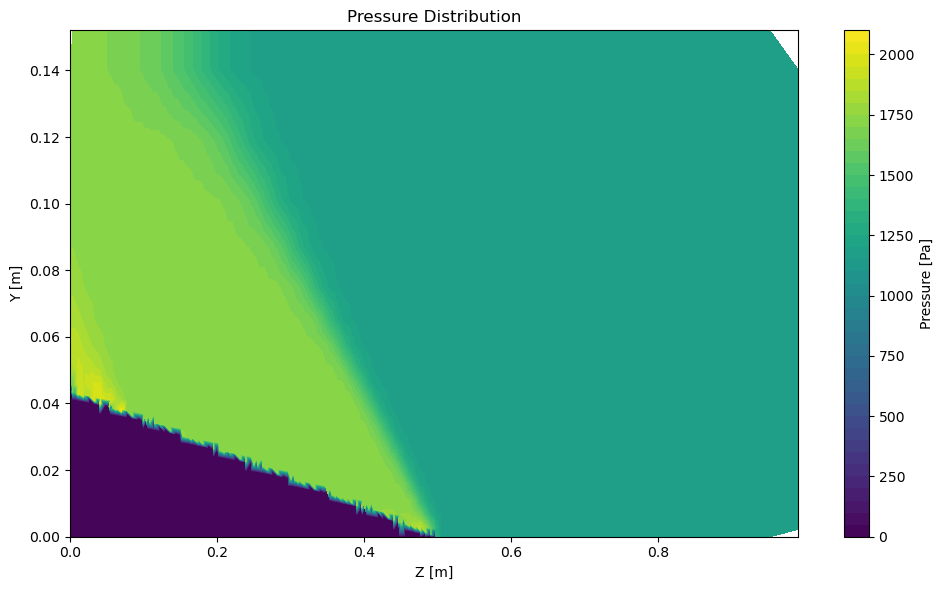

In [ ]:
plt.figure(figsize=(10, 6))
contour = plt.tricontourf(data['Z [m]'][data['Pressure [Pa]'].notna()], 
						 data['Y [m]'][data['Pressure [Pa]'].notna()], 
						 data['Pressure [Pa]'][data['Pressure [Pa]'].notna()],
						 levels=50,
						 cmap='viridis')

plt.colorbar(contour, label='Pressure [Pa]')

# Update labels to reflect the swapped axes
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.title('Pressure Distribution')

plt.tight_layout()
plt.show()


# Analysing the data

In [46]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

In [47]:
data_clean = (
	data[['Y [m]', 'Z [m]', 'Pressure [Pa]']]
	.query("`Y [m]` < 0.08")
	.dropna()
	.copy()
)

In [48]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_clean)



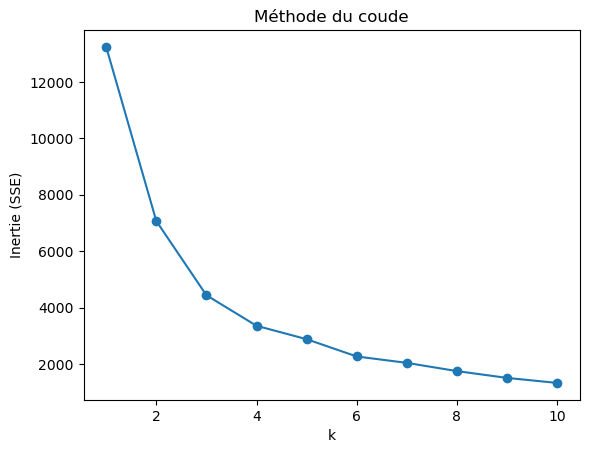

In [49]:
inertias = []
K_range = range(1, 11)          # testez 1→10 clusters

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertias.append(km.inertia_)   # somme des distances intra-cluster

plt.plot(K_range, inertias, 'o-')
plt.xlabel("k")
plt.ylabel("Inertie (SSE)")
plt.title("Méthode du coude")
plt.show()

Interprétez le « coude » : là où la baisse d’inertie devient marginale, c’est que l’on a atteint l’essentiel de la structure.

In [63]:
best_k = 3   # supposons qu'après analyse, 4 est idéal

In [64]:
km_final = KMeans(best_k, random_state=42)
data_clean['cluster'] = km_final.fit_predict(X_scaled)

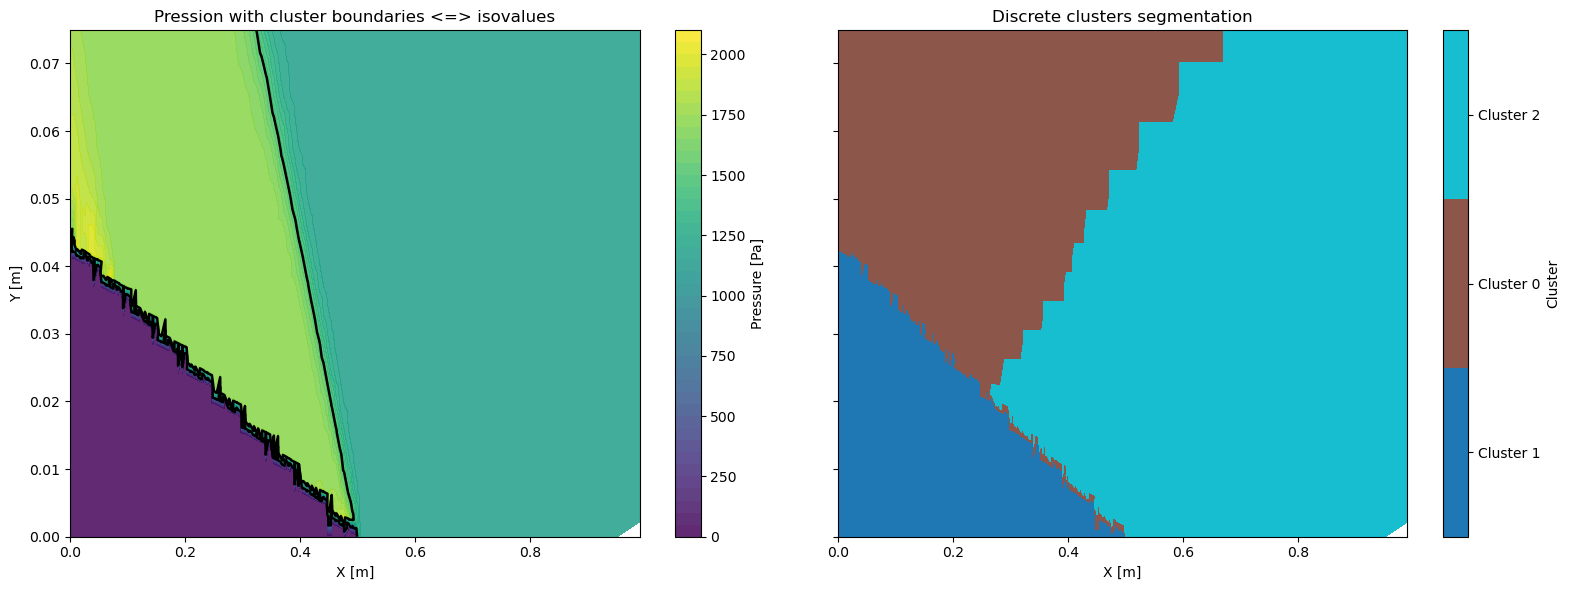

In [71]:
# --- 0) Seuils iso-pression ----------------------------------------
centers_scaled   = km_final.cluster_centers_
centers_real     = scaler.inverse_transform(centers_scaled)
centers_pressure = np.sort(centers_real[:, 2])
thresholds_pressure = (centers_pressure[:-1] + centers_pressure[1:]) / 2

# --- 1) DataFrame prêt --------------------------------------------
plot_df = data_clean.copy()                  # lignes sans NaN / –1
plot_df['cluster_id'], uniques = pd.factorize(plot_df['cluster'])
n_clusters = len(uniques)

# --- 2) Figure -----------------------------------------------------
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# A) Zones pleines de cluster (discret)
bounds = np.arange(-0.5, n_clusters + 0.5, 1)
cmap   = plt.get_cmap('tab10', n_clusters)

cs1 = ax1.tricontourf(
    plot_df['Z [m]'], plot_df['Y [m]'], plot_df['cluster_id'],
    levels=bounds, cmap=cmap, extend='neither'
)
ax1.set_title('Discrete clusters segmentation') 
ax1.set_xlabel('X [m]')

cbar1 = fig.colorbar(cs1, ax=ax1, ticks=np.arange(n_clusters))
cbar1.ax.set_yticklabels([f'Cluster {k}' for k in uniques])
cbar1.set_label('Cluster')

# B) Carte de pression + isovaleurs lisses
cs0 = ax0.tricontourf(
    plot_df['Z [m]'], plot_df['Y [m]'], plot_df['Pressure [Pa]'],
    levels=50, cmap='viridis', alpha=0.85, zorder=0
)

ax0.tricontour(
    plot_df['Z [m]'], plot_df['Y [m]'], plot_df['Pressure [Pa]'],
    levels=thresholds_pressure, colors='k', linewidths=1.8, zorder=1
)

ax0.set_title('Pression with cluster boundaries <=> isovalues')
ax0.set_xlabel('X [m]')
ax0.set_ylabel('Y [m]')

cbar0 = fig.colorbar(cs0, ax=ax0)
cbar0.set_label('Pressure [Pa]')

fig.tight_layout(w_pad=3)
plt.show()

In [66]:
from sklearn.linear_model import RANSACRegressor, LinearRegression

# ---------------- données & seuils ---------------------------------
plot_df = data_clean.copy()
centers_scaled = km_final.cluster_centers_             # Keep original shape (k, n_features)
centers_pa = scaler.inverse_transform(centers_scaled)  # Inverse transform
centers_pressure = centers_pa[:, 2]                   # Get pressure values only
centers_pressure.sort()                               # Sort pressure values
thresholds = (centers_pressure[:-1] + centers_pressure[1:]) / 2  # nb: k-1 seuils

results = []

for i, P_t in enumerate(thresholds, start=1):
	# 1) points "proches" de la frontière (±5 % de la gamme)
	tol = 0.05 * (plot_df['Pressure [Pa]'].max() - plot_df['Pressure [Pa]'].min())
	mask = np.abs(plot_df['Pressure [Pa]'] - P_t) < tol
	sub = plot_df.loc[mask, ['Z [m]', 'Y [m]']].values  # Swap Z and Y columns
	
	# Skip if not enough points found
	if len(sub) < 10:
		continue

	# 2) régression robuste Y = mZ + q
	model = RANSACRegressor(LinearRegression(), min_samples=10, residual_threshold=tol)
	Z = sub[:,0].reshape(-1,1)  # Z is now independent variable
	Y = sub[:,1]                # Y is now dependent variable
	model.fit(Z, Y)
	m = model.estimator_.coef_[0]
	q = model.estimator_.intercept_
	
	results.append((i, P_t, m, q, model.score(Z, Y)))   # R² local

# ---------------- affichage des équations --------------------------
for i, P_t, m, q, r2 in results:
	print(f"Frontière {i} (seuil P = {P_t:.1f} Pa) :  Y = {m:.4f}·Z + {q:.2f}   (R² = {r2:.3f})")

Frontière 2 (seuil P = 1488.4 Pa) :  Y = -0.4299·Z + 0.21   (R² = 0.993)


In [67]:
# Calculate angles in degrees for each border line
angles = []
for i, (cluster_id, P_t, m, q, r2) in enumerate(results, 1):
	angle = np.degrees(np.arctan(m))
	angles.append(angle)
	print(f"Border {i} (P = {P_t:.1f} Pa): angle = {angle:.2f}°")

Border 1 (P = 1488.4 Pa): angle = -23.26°


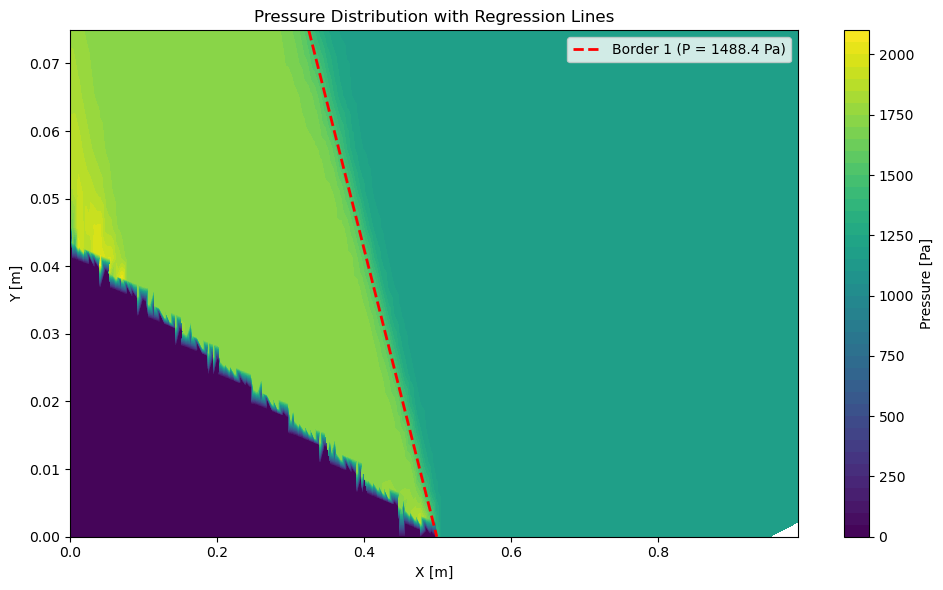

In [72]:
# Plot the pressure distribution with regression lines
plt.figure(figsize=(10, 6))

# Plot pressure distribution
contour = plt.tricontourf(data_clean['Z [m]'], data_clean['Y [m]'], data_clean['Pressure [Pa]'],
						 levels=50, cmap='viridis')
plt.colorbar(contour, label='Pressure [Pa]')

# Define colors for different borders
border_colors = ['r', 'b']  # Add more colors if needed

# Plot regression lines only within data range
for i, (cluster_id, P_t, m, q, r2) in enumerate(results, 1):
	# Get min and max Y values from the actual data
	y_min = data_clean['Y [m]'].min()
	y_max = data_clean['Y [m]'].max()
	
	# Calculate corresponding Z values using the regression equation
	z_at_y_min = (y_min - q) / m
	z_at_y_max = (y_max - q) / m
	
	# Create points for the line, bounded by data range in both Y and Z directions
	z_min = data_clean['Z [m]'].min()
	z_max = data_clean['Z [m]'].max()
	
	# Find the intersection of the two ranges
	z_start = max(min(z_at_y_min, z_at_y_max), z_min)
	z_end = min(max(z_at_y_min, z_at_y_max), z_max)
	
	z = np.linspace(z_start, z_end, 100)
	y = m * z + q
	
	# Only plot if there are valid points within the range
	if len(z[y >= y_min]) > 0 and len(z[y <= y_max]) > 0:
		plt.plot(z, y, color=border_colors[i-1], linestyle='--', linewidth=2, 
				label=f'Border {i} (P = {P_t:.1f} Pa)')

plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.title('Pressure Distribution with Regression Lines')
plt.legend()
plt.tight_layout()
plt.show()